<a href="https://colab.research.google.com/github/WoogiWooks/DLCV_New/blob/main/1_Object_Detection_%EC%9D%B4%ED%95%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Detection의 난제 (해결해야 할 점)**
* 분류와 박스회귀가 동시에 진행하여 둘 모두의 Loss를 줄여야 함
* 다양한 오브젝트가 섞여있는 이미지의 특성
* Detect 시간이 실시간적으로 이루어져야 하며 성능도 보장되어야 함
* 이미지가 명확하지 않거나 타겟대상이 매우작고 배경이 대부분을 차지하는 경우
* 데이터별 annotation 작업을 해줘야함으로써 훈련 데이터 세트 생성이 어려움

# **Computer Vision**
* Classification : 이 이미지는 ~이다

* Localization : 이 이미지 속 이것은 ~이다 (타겟 1개, Detection에 비해 쉬움)

* Detection : 이 이미지 속 이것은 ~이고 또 다른 이것은 ~이고 (타겟 2개 이상, Box로)

* Segmentation : 이 이미지 속 이것은 ~이고 또 다른 이것은 ~이고  (개별 픽셀로)

# **따라서 Detection은 타겟이 있을만한 위치를 추정해주어야 함**
* Sliding Window 방식 : Detection 초기 기법으로 수행 시간 오래 걸리고 낮은 성능 
  
      => 다양한 형태의 Window 사용은 나중에 앵커박스에, 이미지 스케일 변경은 SSD와 FPN에 개념이 사용됨

* Region Proposal 방식 (Selective Search) : 이미지의 고주파, 저주파 차이, 텍스쳐, 밝기 등에 따라 유사한 지역을 그룹핑 후 비슷한 그룹끼리 합쳐나가며 그룹핑을 반복 수행하여 Object가 있을만한 위치를 결정함

# **Detection 성능평가**

* IoU : Ground Truth와 Predicted Box 합친 영역 중 서로 겹치는 영역의 비율
       많이 겹칠수록, 즉 성능이 좋을수록 1에 가깝다
       대회에 따라 IoU에 따른 성능평가 기준이 다르다 (0.7 을 Good으로 보는 곳도, Poor로 보는 곳도 있다)


In [ ]:
# IoU 계산 함수
# gt_box = [xg1, yg1, xg2, yg2]
# cand_box = [xc1, yc1, xc2, yc2]

def IoU(cand_box, gt_box):
  x1 = np.max(cand_box[0], gt_box[0])
  y1 = np.max(cand_box[1], gt_box[1])
  x2 = np.min(cand_box[2], gt_box[2])
  y2 = np.min(cand_box[3], gt_box[3])

  intersection = abs(x2-x1) * abs(y2-y1)

  cand_box_area = abs(cand_box[2]-cand_box[0]) * abs(cand_box[3]-cand_box[1])
  gt_box_area = abs(gt_box[2]-gt_box[0]) * abs(gt_box[3]-gt_box[1])

  union = cand_box_area + gt_box_area - intersection
  IoU = intersection/union

  return IoU

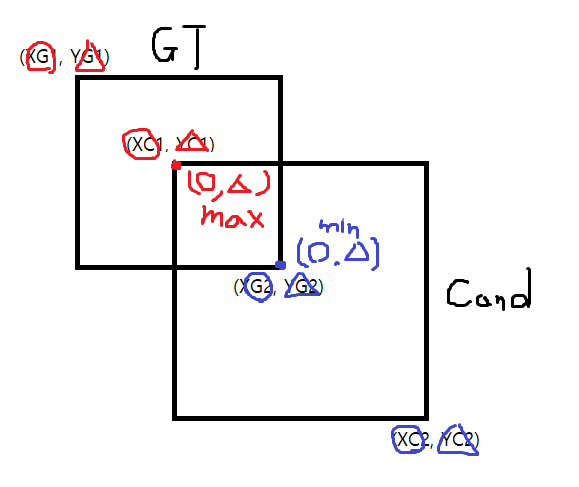

* AP : 한 개 오브젝트에 대한 Precision과 Recall의 조화 정도에 대한 성능 수치로, Confidence Threshold값의 조정으로 인한 Recall값의 변화에 따른 Precision의 변화를 나타낸 그래프의 면적
         AP가 클 수록 Recall과 Precision 모두가 좋은 성능을 보이는(트레이드 오프되는 정도가 작음), 오브젝트를 잘 찾고 잘 맞추는 모델\

* mAP : 여러 오브젝트들의 AP를 평균한 값
        True Positive에 대한 기준 IoU가 높으면 TP분류가 어려워지므로 AP가 낮아지게됨 

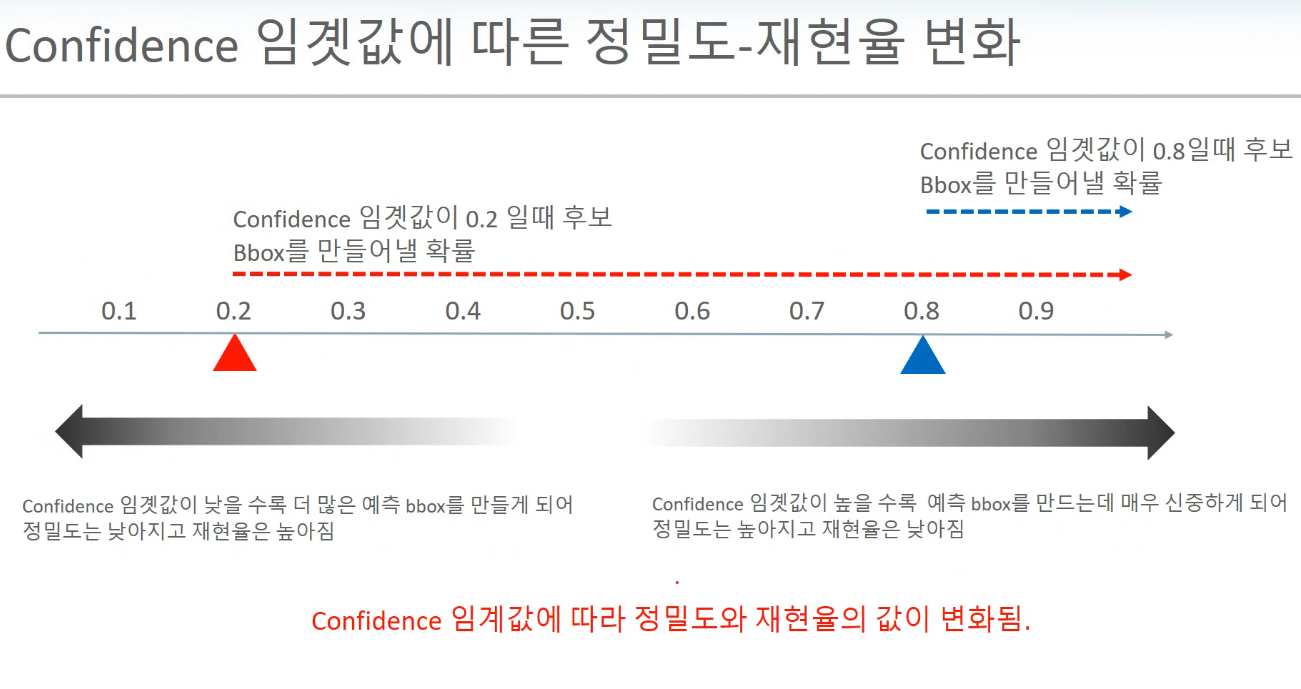

# **Non-Max Suppression (NMS)**

* Object 가 있을 만한 위치에 많은 Detection을 수행하고 Box가 형성되는데, 비슷한 위치에 있는 Box를 제거하고 가장 적합한 Box를 선택하는 기법
      1. Confidence Score Threshold 이하의 Box 제거
      2. 높은 Confidence Score 가지는 Box와 겹치는 다른 Box들 사이의 IoU를 계산하여, IoU Threshold 이상인 Box는 제거 (많이 겹치는것 제거)
      3. 다음으로 높은 Confidence Score 가지는 Box 대상으로 동일 진행하며 계속 반복하여 남아 있는 Box만 선택